In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.name

if os.name == 'posix': 
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) 

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import cv2
from glob import glob
from PIL import Image
import json
import seaborn as sns
import os
import pickle
import time
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected" 
from endecoder import *

## 이미지 크기

In [40]:
vaild_dir = os.path.join(root, "valid")
img_dir = os.path.join(vaild_dir, "images")
crops = glob(img_dir + '\*')

In [43]:
w_list = []
h_list = []
for path in crops:
    crop_list = glob(path + '\*.jpg')
    for img_path in crop_list:
        img = Image.open(img_path)
        w, h = img.size
        w_list.append(w)
        h_list.append(h)  

In [44]:
# 작물 평균 이미지 크기
np.mean(w), np.mean(h)

(4032.0, 3024.0)

## EDA 시작

In [4]:
df = pd.read_csv("meta.csv")

C:\Users\user0721\AppData\Local\Temp\ipykernel_19012\3421688178.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



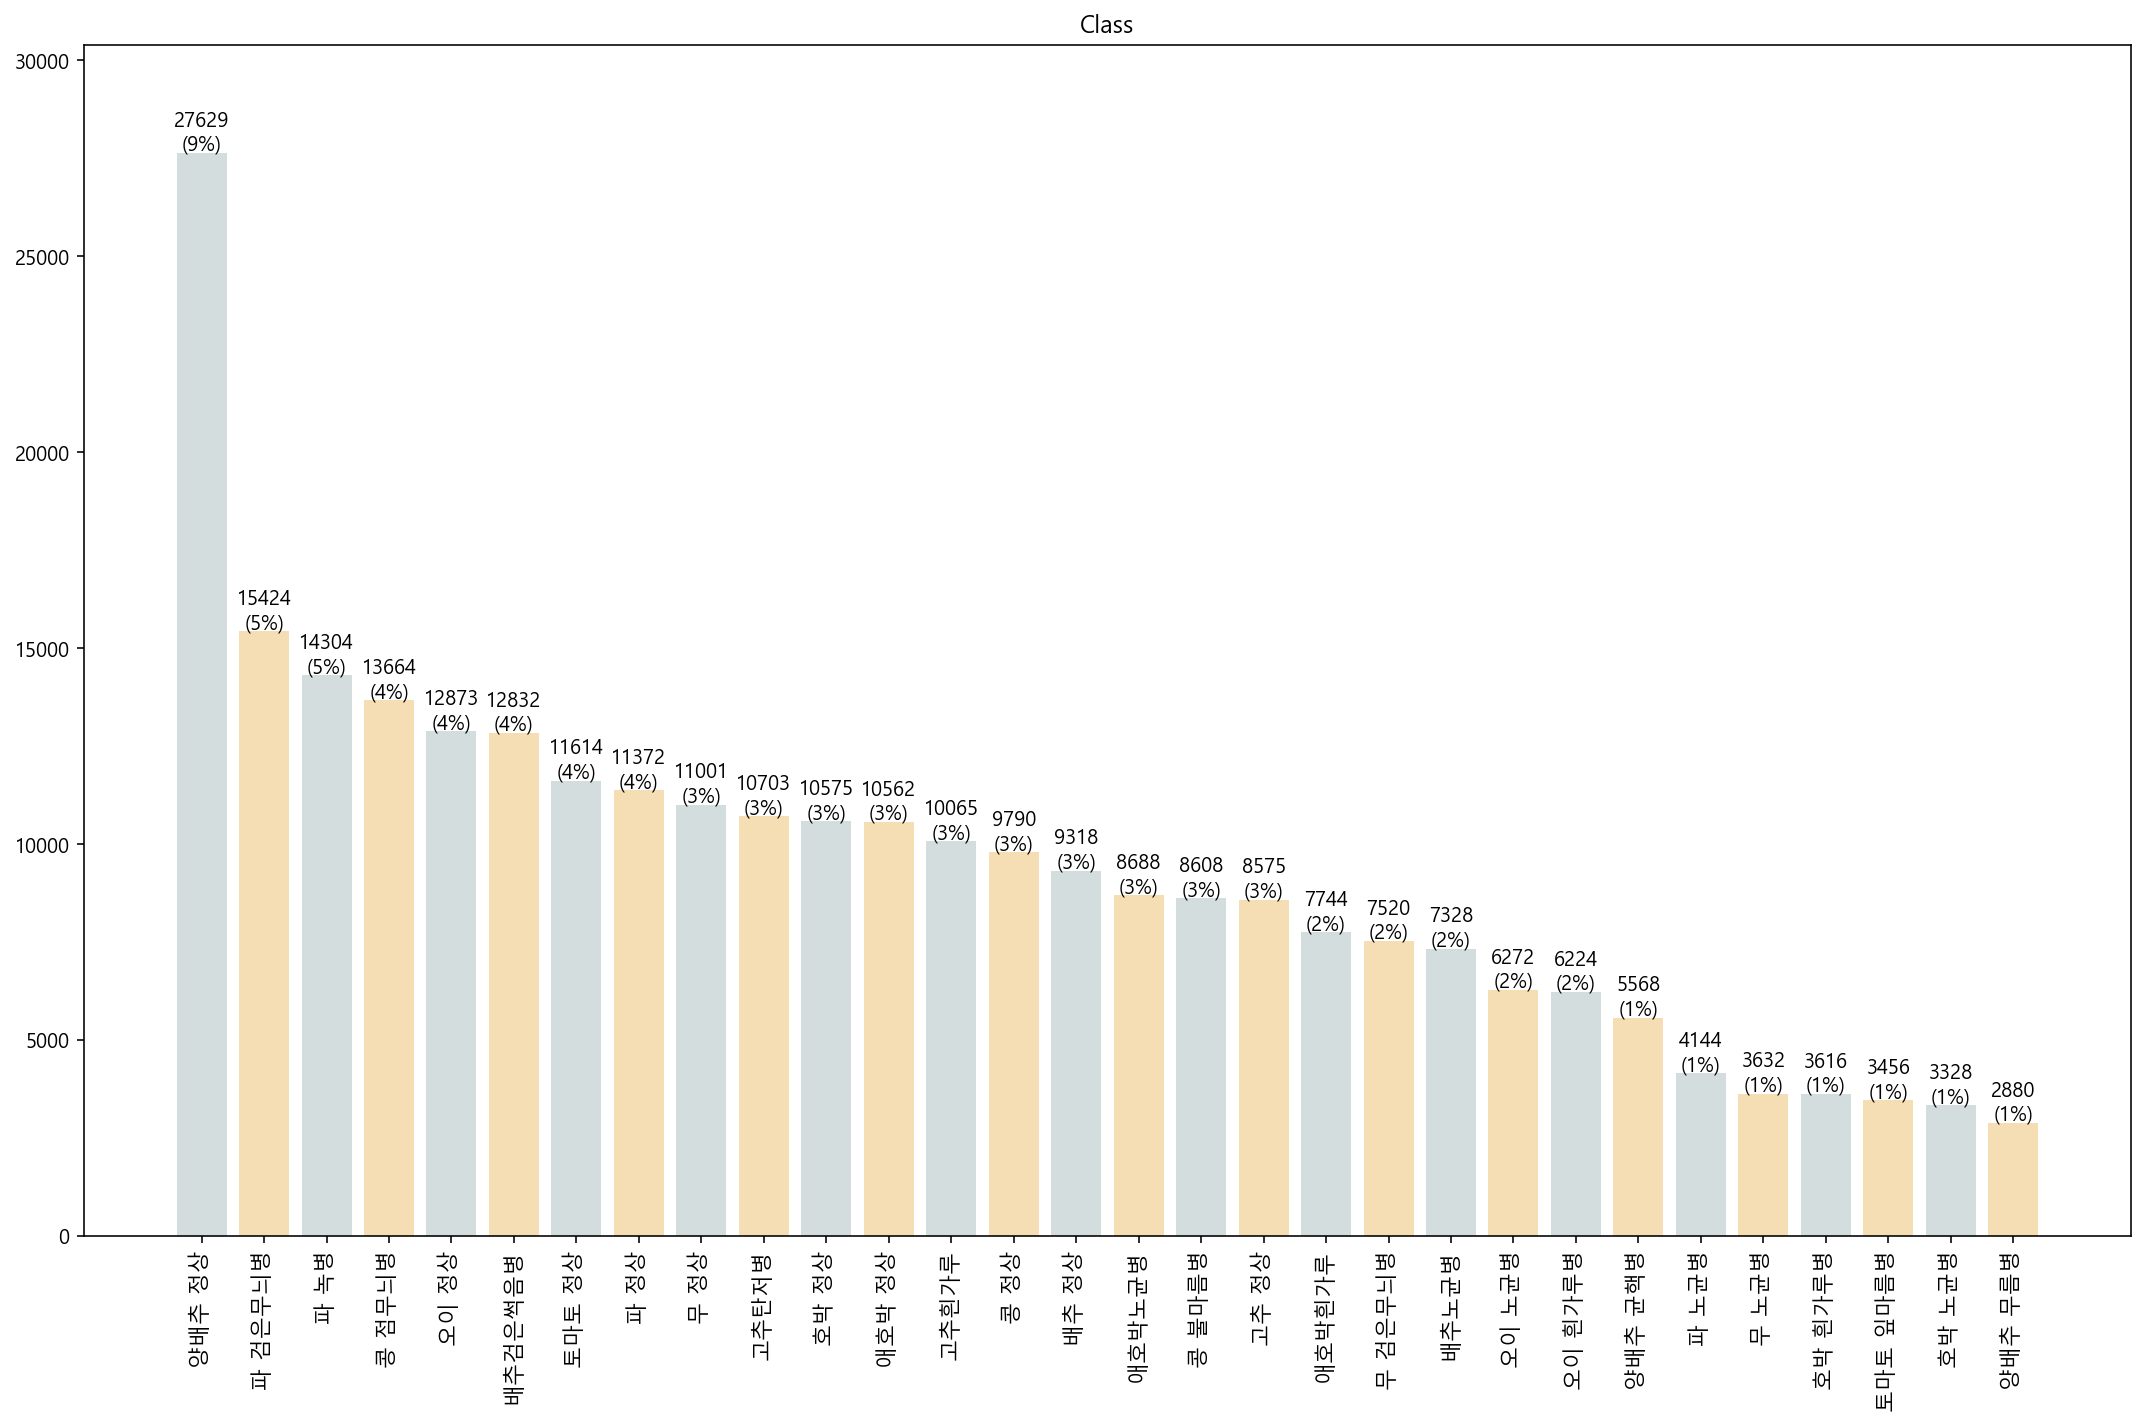

In [6]:
# 전체 데이터 병 분포도 확인

f, axs = plt.subplots(1,figsize=(15,10))

object_cnt = df["disease"].value_counts().sort_values(ascending=False)
name_list = [crop_aware_name_decoder[i] for i in object_cnt.index.tolist()]

axs.bar(name_list, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(len(name_list))])
for x,y,z in zip(range(len(name_list)), object_cnt.values,object_cnt.values/object_cnt.sum()*100):        
    axs.annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
axs.axis(ymin=0,ymax=int(max(object_cnt)*1.1))
axs.set_xticklabels(name_list, rotation = 90,fontsize = 11)
axs.set_title("Class")
f.tight_layout()
plt.show()

In [7]:
df0 = df[df["code"] == 0]
df1 = df[df["code"] == 1].reset_index(drop=True)
df2 = df[df["code"] == 2].reset_index(drop=True)

C:\Users\user0721\AppData\Local\Temp\ipykernel_19012\2382480655.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



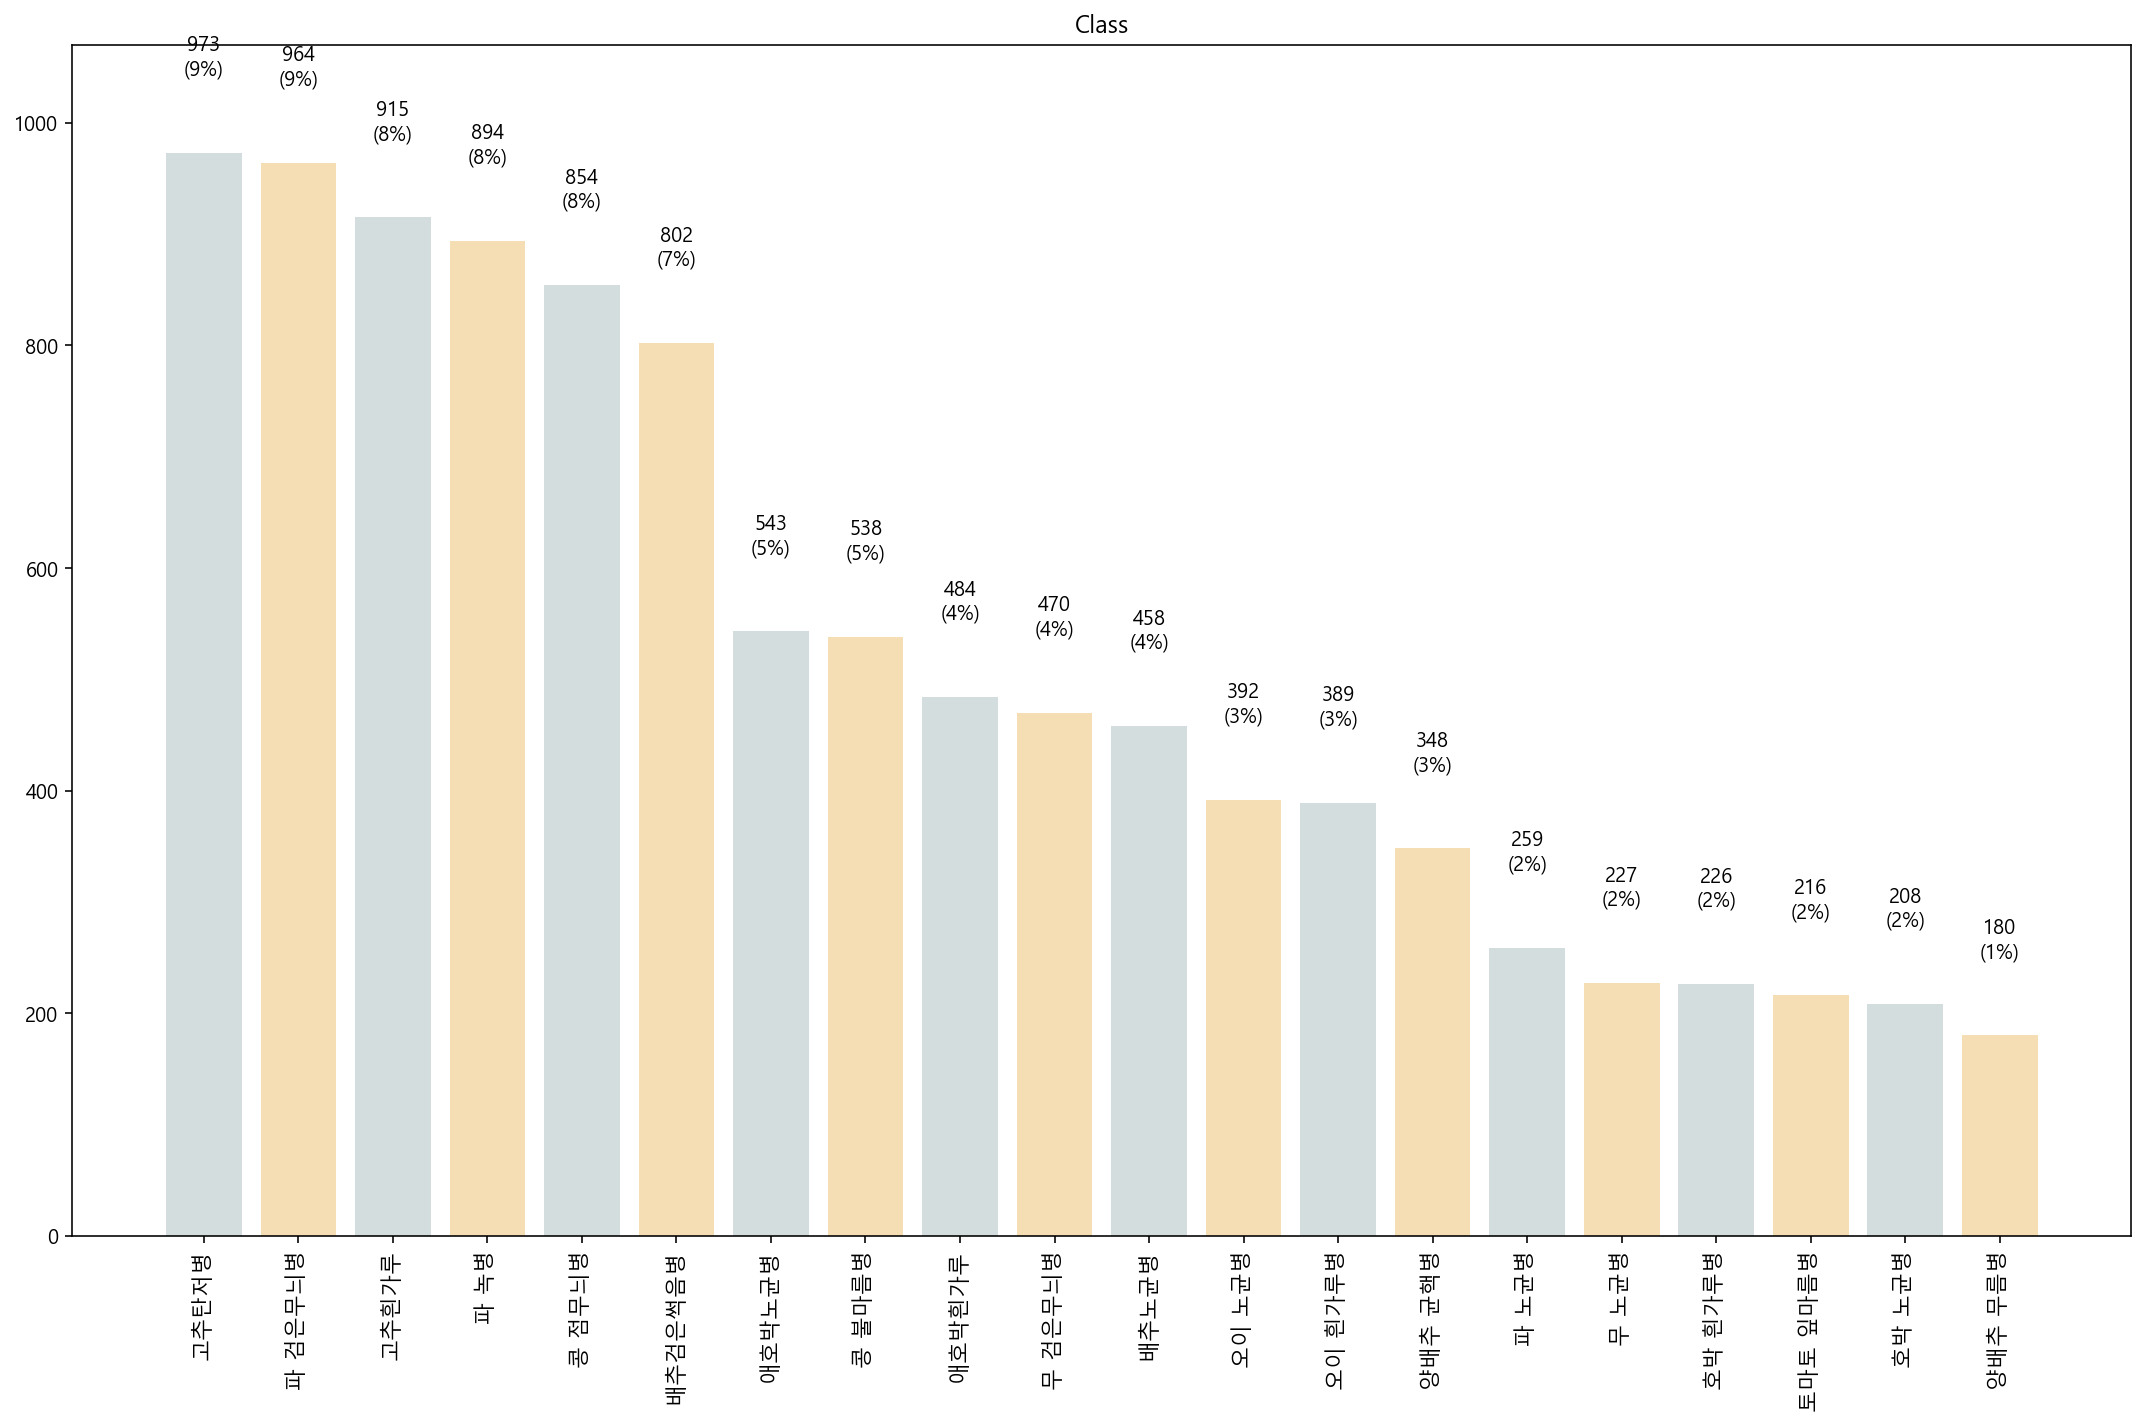

In [8]:
# 질병 데이터 분포 확인
f, axs = plt.subplots(1,figsize=(15,10))

object_cnt = df0["disease"].value_counts().sort_values(ascending=False)
name_list = [crop_aware_name_decoder[i] for i in object_cnt.index.tolist()]
axs.bar(name_list, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(len(name_list))])
for x,y,z in zip(range(len(name_list)), object_cnt.values,object_cnt.values/object_cnt.sum()*100):        
    axs.annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
axs.axis(ymin=0,ymax=int(max(object_cnt)*1.1))
axs.set_xticklabels(name_list, rotation = 90,fontsize = 11)
axs.set_title("Class")
f.tight_layout()
plt.show()

C:\Users\user0721\AppData\Local\Temp\ipykernel_12704\2110474568.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



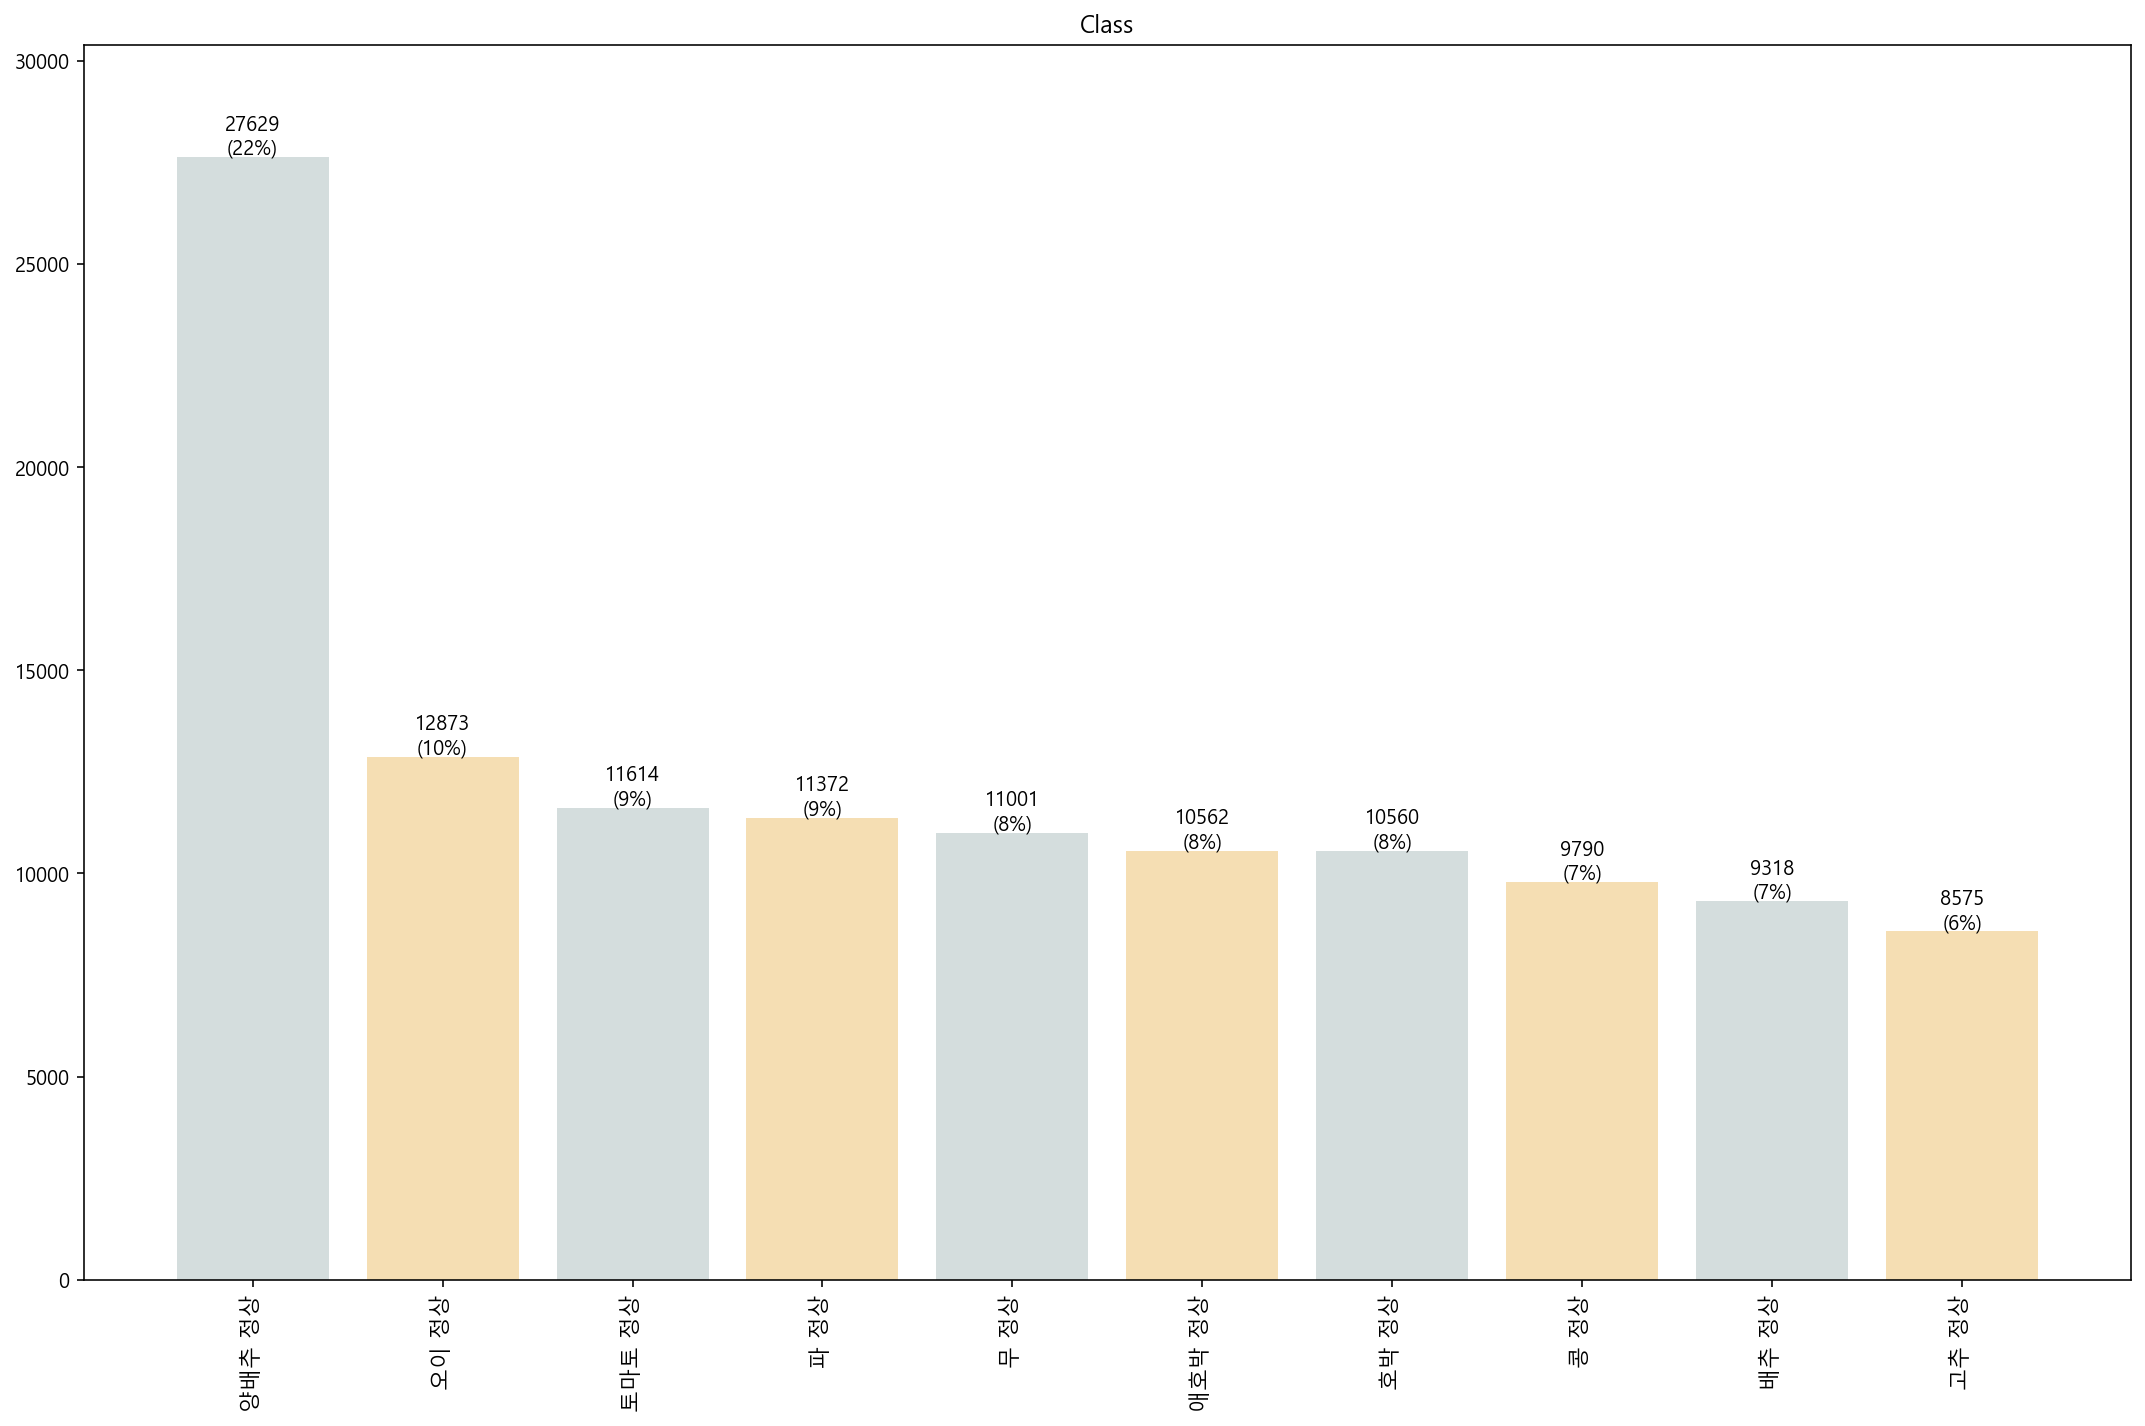

In [76]:
# 정상 데이터 분포 확인
f, axs = plt.subplots(1,figsize=(15,10))

object_cnt = df1["disease"].value_counts().sort_values(ascending=False)
name_list = [crop_aware_name_decoder[i] for i in object_cnt.index.tolist()]
axs.bar(name_list, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(len(name_list))])
for x,y,z in zip(range(len(name_list)), object_cnt.values,object_cnt.values/object_cnt.sum()*100):        
    axs.annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
axs.axis(ymin=0,ymax=int(max(object_cnt)*1.1))
axs.set_xticklabels(name_list, rotation = 90,fontsize = 11)
axs.set_title("Class")
f.tight_layout()
plt.show()

C:\Users\user0721\AppData\Local\Temp\ipykernel_12704\3186374579.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



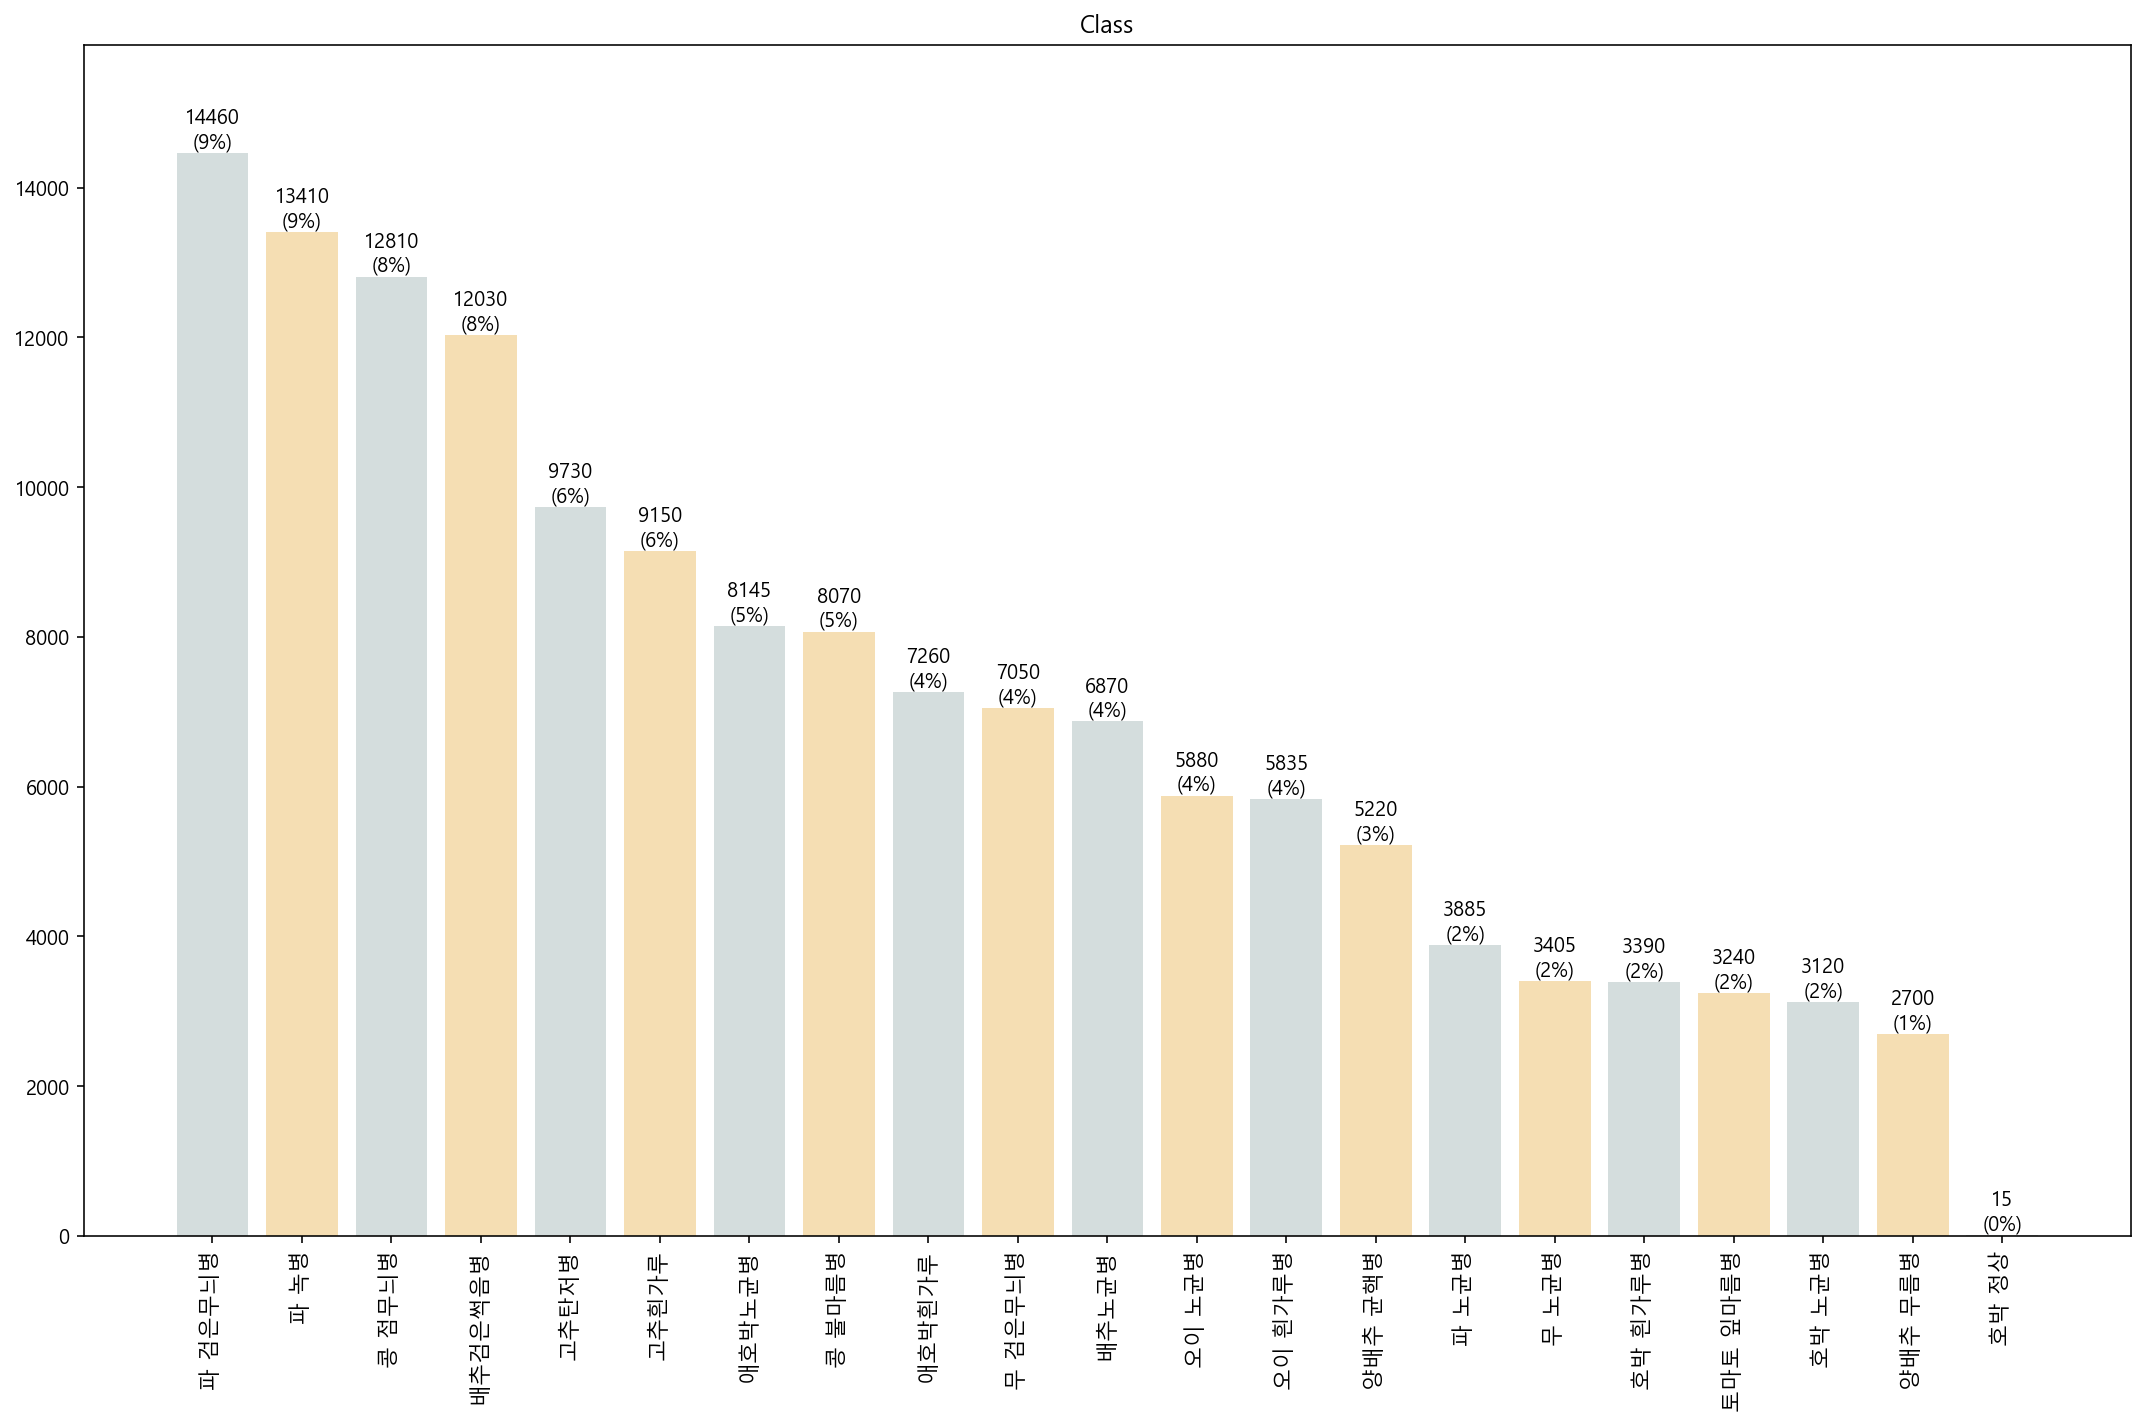

In [77]:
# 증강 데이터 분포 확인
f, axs = plt.subplots(1,figsize=(15,10))

object_cnt = df2["disease"].value_counts().sort_values(ascending=False)
name_list = [crop_aware_name_decoder[i] for i in object_cnt.index.tolist()]
axs.bar(name_list, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(len(name_list))])
for x,y,z in zip(range(len(name_list)), object_cnt.values,object_cnt.values/object_cnt.sum()*100):        
    axs.annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
axs.axis(ymin=0,ymax=int(max(object_cnt)*1.1))
axs.set_xticklabels(name_list, rotation = 90,fontsize = 11)
axs.set_title("Class")
f.tight_layout()
plt.show()
"""
질병데이터에 호박 정상인 오분류데이터 존재 -> 삭제 필요
"""

In [304]:
df0 = pd.read_csv("질병.csv")
df1 = pd.read_csv("정상.csv")
df2 = pd.read_csv("증강.csv")

In [10]:
meta_df = pd.concat([df0, df1, df2]).reset_index(drop=True)

In [12]:
# 질병별 피해정도
tmp = meta_df.groupby('crop')['disease'].value_counts().rename('cnt').reset_index()
tmp2 = meta_df.groupby(['disease'])['risk'].value_counts().rename('cnt').reset_index()

tmp['crop'] = tmp['crop'].apply(lambda x : crop_decoder_kr[str(x).zfill(2)])
tmp['disease'] = tmp['disease'].apply(lambda x : crop_aware_name_decoder[x])
tmp2['disease'] = tmp2['disease'].apply(lambda x : crop_aware_name_decoder[x])
tmp2['risk'] = tmp2['risk'].apply(lambda x : risks[x])

i = 0
tmp_dict = {}
for c_list in [tmp['crop'].unique(), tmp['disease'].unique(), tmp2['risk'].unique()]:
    for x in c_list:
        tmp_dict[x] = i
        i+=1 

NODES = dict(
label = list(tmp_dict.keys()),
)
LINKS = dict(   source = list(tmp['crop'].map(tmp_dict).values) + list(tmp2['disease'].map(tmp_dict).values), 
target = list(tmp['disease'].map(tmp_dict).values) + list(tmp2['risk'].map(tmp_dict).values),
value =  list(tmp['cnt'].values) + list(tmp2['cnt'].values), 
)
data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()
fig.write_html('crop_dis_type.html')
"""
피해 정도 부분

정상은 10가지 작물의 정상이 있고 말기, 중기, 초기에는 모든 작물데이터의 질병이 존재

"""

In [13]:
# 부위별 병 발생
tmp = meta_df.groupby('crop')['area'].value_counts().rename('cnt').reset_index()
tmp2 = meta_df.groupby(['area'])['disease'].value_counts().rename('cnt').reset_index()

tmp['crop'] = tmp['crop'].apply(lambda x : crop_decoder_kr[str(x).zfill(2)])
tmp['area'] = tmp['area'].apply(lambda x : area_dict[x])
tmp2['area'] = tmp2['area'].apply(lambda x : area_dict[x])
tmp2['disease'] = tmp2['disease'].apply(lambda x : crop_aware_name_decoder[x])

i = 0
tmp_dict = {}
for c_list in [tmp['crop'].unique(), tmp['area'].unique(), tmp2['disease'].unique()]:
    for x in c_list:
        tmp_dict[x] = i
        i+=1 
        
NODES = dict(
label = list(tmp_dict.keys()),
)
LINKS = dict(   source = list(tmp['crop'].map(tmp_dict).values) + list(tmp2['area'].map(tmp_dict).values), 
target = list(tmp['area'].map(tmp_dict).values) + list(tmp2['disease'].map(tmp_dict).values), 
value =  list(tmp['cnt'].values) + list(tmp2['cnt'].values), 
)
data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()
fig.write_html('crop_area_dis.html')

"""
열매부분 작물은 고추, 토마토, 오이, 애호박, 호박, 양배추, 콩이 있고 질병 종류는 앞에 7가지 정물 정상과 양배추 무름병 데이터 존재

꽃부분 작물은 고추, 토마토, 오이 애호박, 콩이 있고 질병 종류는 앞에 5가지 작물의 정상데이터 존재

줄기 부분은 고추, 토마토, 오이, 애호박, 호박, 콩이 있고, 질병 종류는 앞에 작물 8가지에 배추 검은썩음, 오이 흰가루 데이터 존재

잎 부분 모든 작물이 있고 질병 종류도 모두 있다.
"""

In [14]:
# 월별 발생량
meta_df['date'] = pd.to_datetime(meta_df['date'])
meta_df['year'] = meta_df['date'].dt.year
meta_df['month'] = meta_df['date'].dt.month

tmp = meta_df.groupby('crop')['month'].value_counts().rename('cnt').reset_index()
tmp2 = meta_df.groupby(['month'])['disease'].value_counts().rename('cnt').reset_index()

tmp['crop'] = tmp['crop'].apply(lambda x : crop_decoder_kr[str(x).zfill(2)])
tmp2['disease'] = tmp2['disease'].apply(lambda x : crop_aware_name_decoder[x])

i = 0
tmp_dict = {}
for c_list in [tmp['crop'].unique(), tmp['month'].unique(), tmp2['disease'].unique()]:
    for x in c_list:
        tmp_dict[x] = i
        i+=1 
        
NODES = dict(
label = list(tmp_dict.keys()),
)
LINKS = dict(   source = list(tmp['crop'].map(tmp_dict).values) + list(tmp2['month'].map(tmp_dict).values), 
target = list(tmp['month'].map(tmp_dict).values) + list(tmp2['disease'].map(tmp_dict).values),
value =  list(tmp['cnt'].values) + list(tmp2['cnt'].values), 
) 
data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()
fig.write_html('crop_month_dis.html')

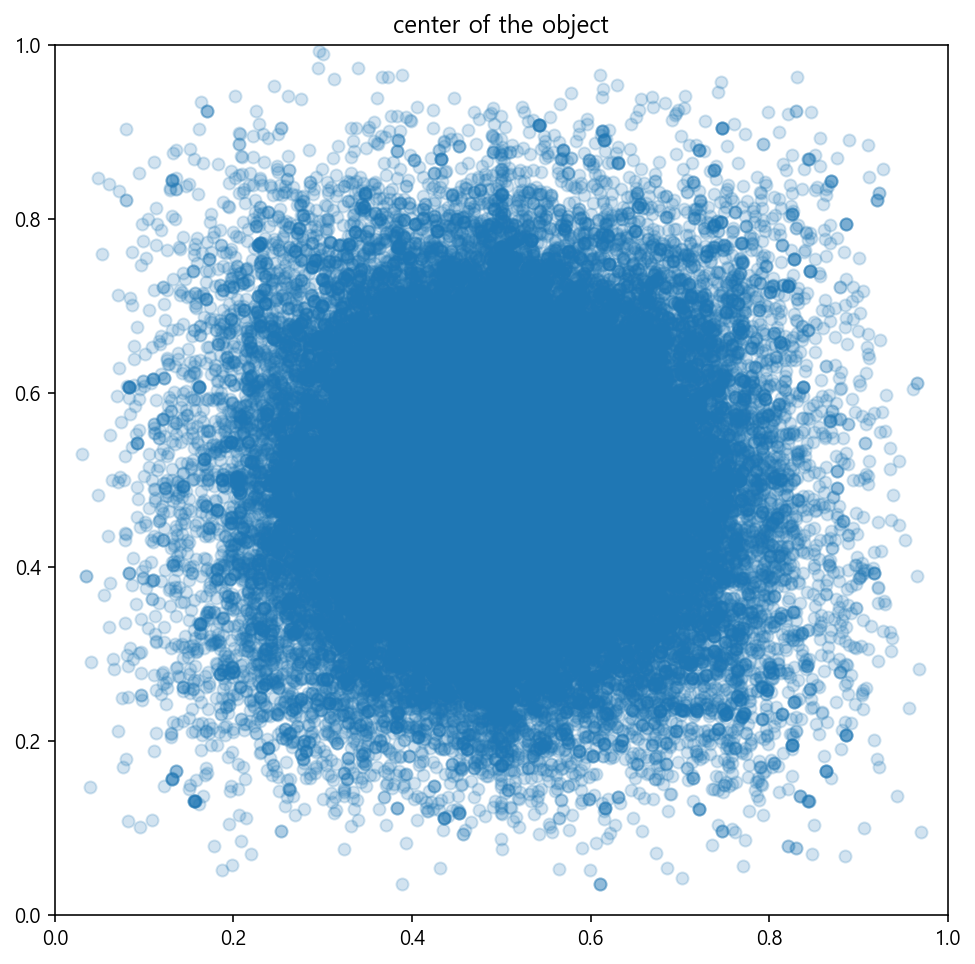

'\n객체위치는 중앙으로부터 퍼지는 형태로 분포되어있다.\n\n'

In [18]:
# 객체 위치 평균
import re

bbox = meta_df['bbox'].apply(lambda x: np.array(re.findall(r'\d+', x)))
x1_list = np.vstack(bbox.values)[:, 0].astype(np.uint)
y1_list = np.vstack(bbox.values)[:, 1].astype(np.uint)
x2_list = np.vstack(bbox.values)[:, 2].astype(np.uint)
y2_list = np.vstack(bbox.values)[:, 3].astype(np.uint)
center_x = ((x2_list + x1_list)/2.) 
center_y = ((y2_list + y1_list)/2.)

plt.figure(figsize=(8,8))
plt.scatter(center_x/meta_df['width'], 
            center_y/meta_df['height'],
           alpha = 0.2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('center of the object')
plt.show()
"""
객체위치는 중앙으로부터 퍼지는 형태로 분포되어있다.

"""